# Advanced Lane Line Findings

Note: All the process to detect lane lines in test video is executed in `process_image` function in `Defining image processing method` section. 

## Camera Calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

print(cv2.__version__)

3.4.9


In [2]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

def collect_callibration_points():
    objpoints = []
    imgpoints = []

    images = glob.glob('./camera_cal/calibration*.jpg')
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

    for fname in images:
        img = mpimg.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    return imgpoints, objpoints

def compare_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


imgpoints, objpoints = collect_callibration_points()
img = mpimg.imread('./camera_cal/calibration3.jpg')
undistorted, mtx, dist_coefficients = cal_undistort(img, objpoints, imgpoints)

image_path = './test_images/straight_lines2.jpg'
image = mpimg.imread(image_path)
image, mtx, dist_coefficients = cal_undistort(image, objpoints, imgpoints)

## Gradient Thresholds

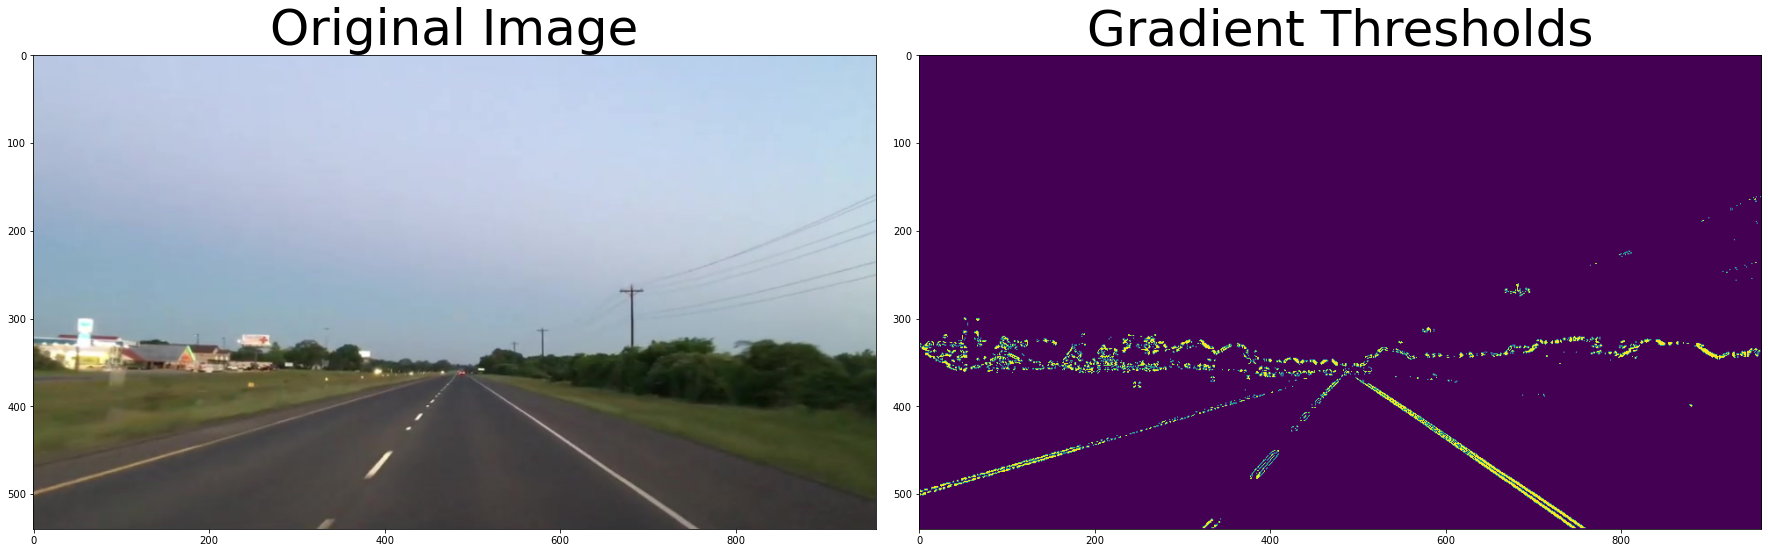

In [3]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    isX = True if orient == 'x' else False
    sobel = cv2.Sobel(gray, cv2.CV_64F, isX, not isX)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return dir_binary

def apply_thresholds(image, ksize=3):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

combined = apply_thresholds(image)
compare_images(image, combined, "Original Image", "Gradient Thresholds")

## Color Threshold

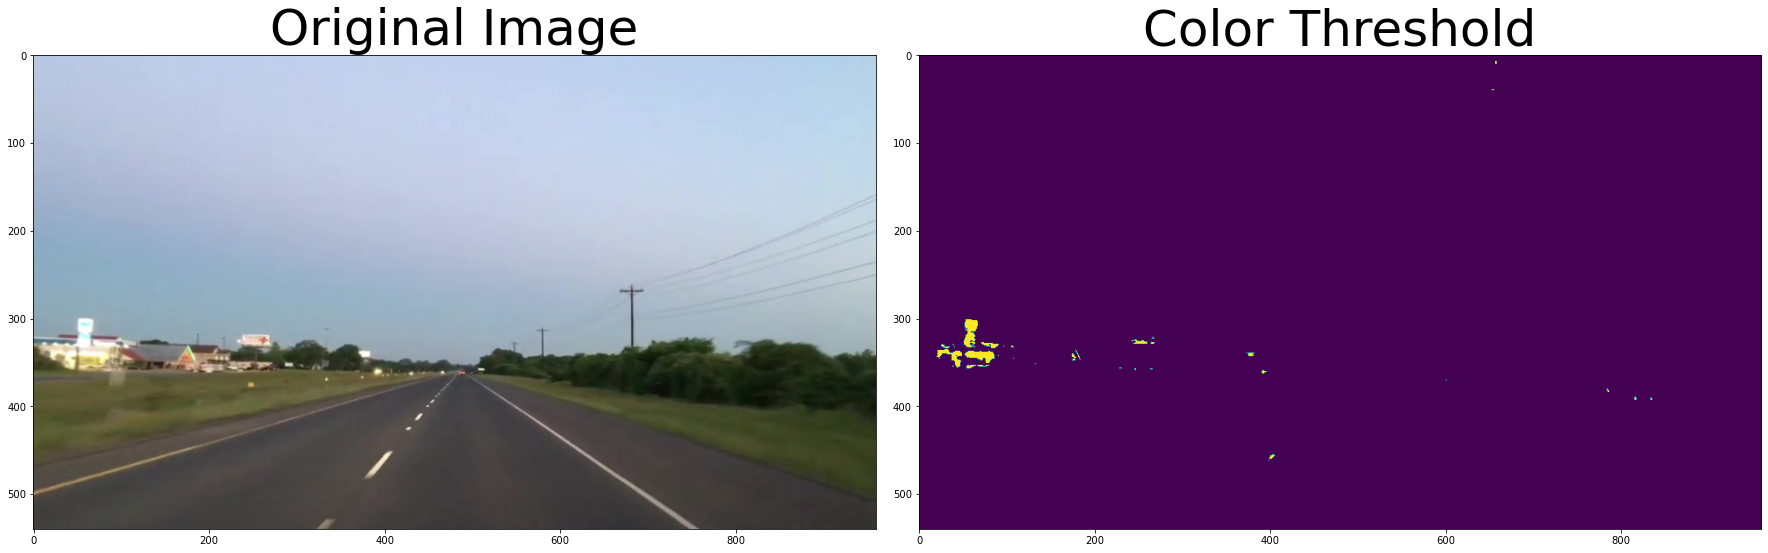

In [4]:
def apply_color_threshold(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    return s_binary 

s_binary = apply_color_threshold(image)
compare_images(image, s_binary, "Original Image", "Color Threshold")

## Combine Color and Gradient

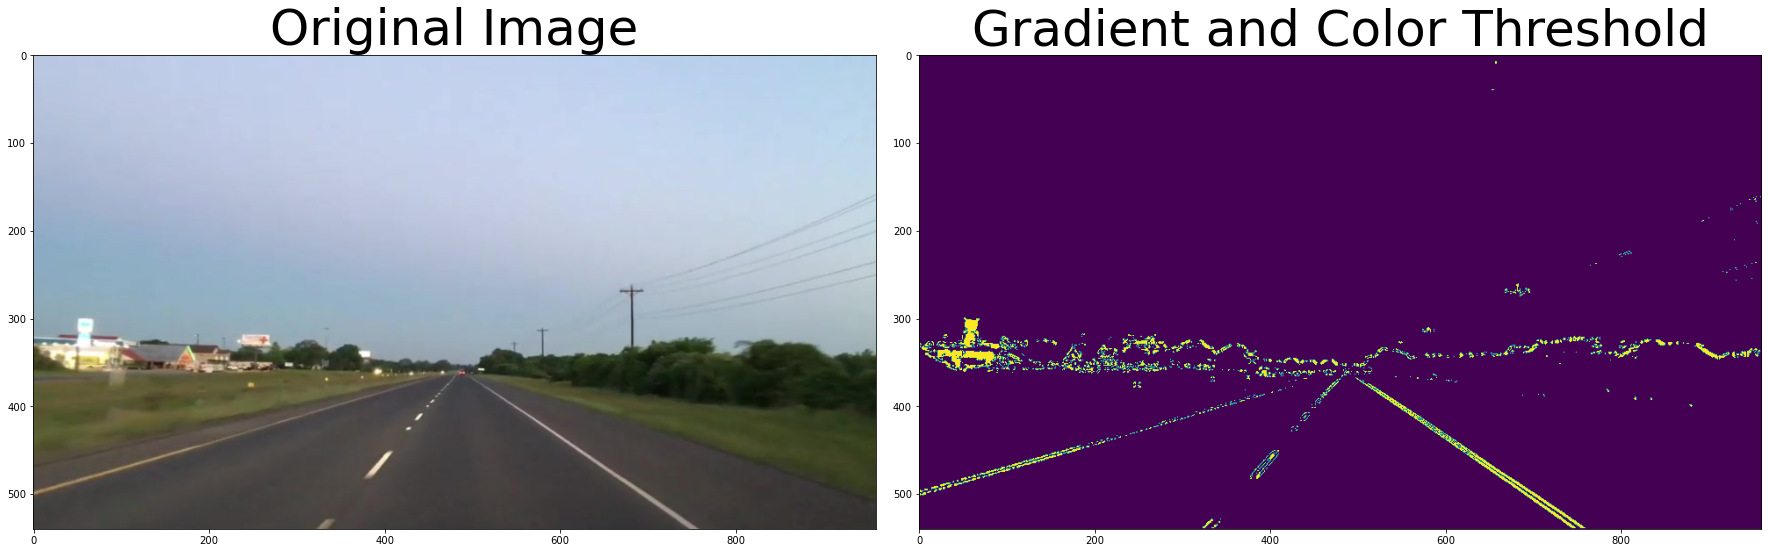

In [5]:
def combine_threshold(s_binary, combined):
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary

combined_binary = combine_threshold(s_binary, combined)
compare_images(image, combined_binary, "Original Image", "Gradient and Color Threshold")

## Perspective Transform

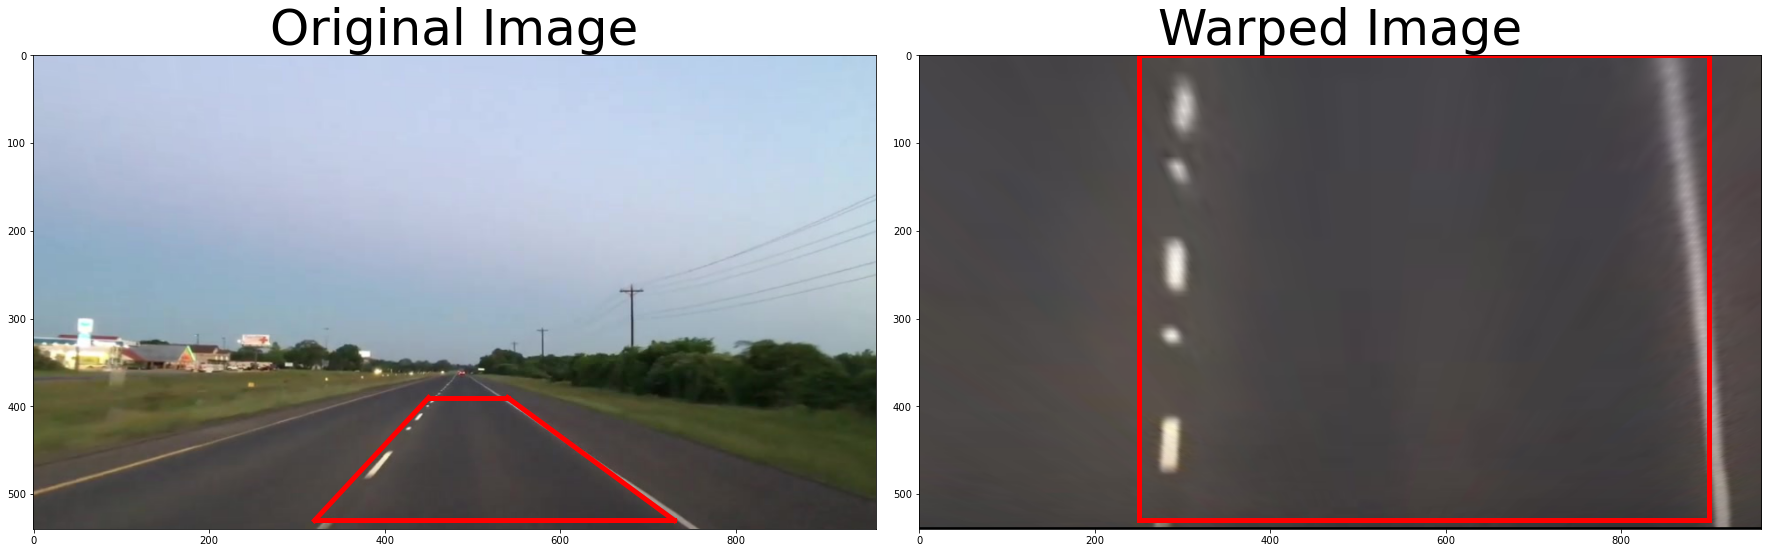

In [6]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[540, 390], 
          [730, 530], 
          [320, 530], 
          [450, 390]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 530], 
          [250, 530], 
          [250, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
   
    return binary_warped, Minv

def compare_plotted_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.plot([540, 730], [390, 530], color='r', linewidth="5")
    ax1.plot([730, 320], [530, 530], color='r', linewidth="5")
    ax1.plot([320, 450], [530, 390], color='r', linewidth="5")
    ax1.plot([450, 540], [390, 390], color='r', linewidth="5")
    ax1.set_title(image1_exp, fontsize=50)
    ax2.imshow(image2)
    ax2.plot([900, 900], [0, 530], color='r', linewidth="5")
    ax2.plot([900, 250], [530, 530], color='r', linewidth="5")
    ax2.plot([250, 250], [530, 0], color='r', linewidth="5")
    ax2.plot([250, 900], [0, 0], color='r', linewidth="5")
    ax2.set_title(image2_exp, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
warped, Minv = warp(image)
compare_plotted_images(image, warped, "Original Image", "Warped Image")

# Finding the Lines

## Histogram

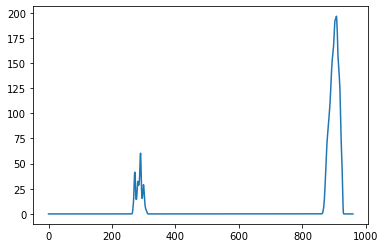

In [7]:
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    return histogram

binary_warped, Minv = warp(combined_binary)
histogram = get_histogram(binary_warped)
plt.plot(histogram)

## Sliding Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


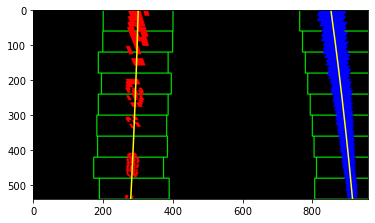

In [8]:
def slide_window(binary_warped, histogram):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 960)
    plt.ylim(540, 0)
    
    return ploty, left_fit, right_fit

ploty, left_fit, right_fit = slide_window(binary_warped, histogram)

## Skipping Slinding Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


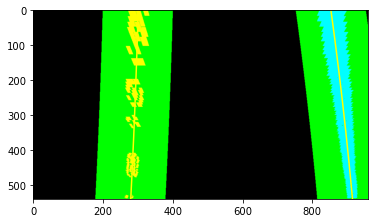

In [9]:
def skip_sliding_window(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  
    
    ################################ 
    ## Visualization
    ################################ 
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 960)
    plt.ylim(540, 0)
    
    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty
    
    return ret

draw_info = skip_sliding_window(binary_warped, left_fit, right_fit)

## Measuring Curvature

In [10]:
def measure_curvature(ploty, lines_info):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 

    leftx = lines_info['left_fitx']
    rightx = lines_info['right_fitx']

    leftx = leftx[::-1]  
    rightx = rightx[::-1]  

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

left_curverad, right_curverad = measure_curvature(ploty, draw_info)

7487.58172566719 m 3852.522168130061 m


## Drawing

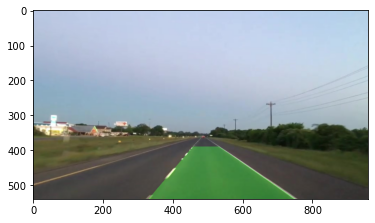

In [11]:
def draw_lane_lines(original_image, warped_image, Minv, draw_info):
    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']
    
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    return result


result = draw_lane_lines(image, binary_warped, Minv, draw_info)
plt.imshow(result)

## Defining image processing method

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8541.3894638307 m 2214.920655636491 m


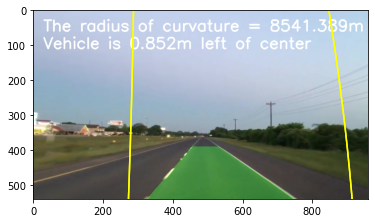

In [12]:
global used_warped
global used_ret

def process_image(image):
    global used_warped
    global used_ret
    
    #Undistort image
    image, mtx, dist_coefficients = cal_undistort(image, objpoints, imgpoints)
    
    # Gradient thresholding
    gradient_combined = apply_thresholds(image)
   
    # Color thresholding
    s_binary = apply_color_threshold(image)
    
    # Combine Gradient and Color thresholding
    combined_binary = combine_threshold(s_binary, gradient_combined)
   
    # Transforming Perspective
    binary_warped, Minv = warp(combined_binary)
  
    # Getting Histogram
    histogram = get_histogram(binary_warped)
  
    # Sliding Window to detect lane lines
    ploty, left_fit, right_fit = slide_window(binary_warped, histogram)
    
    # Skipping Sliding Window
    ret = skip_sliding_window(binary_warped, left_fit, right_fit)
   
    # Measuring Curvature
    left_curverad, right_curverad = measure_curvature(ploty, ret)
    
     # Sanity check: whether the lines are roughly parallel and have similar curvature
    slope_left = ret['left_fitx'][0] - ret['left_fitx'][-1]
    slope_right = ret['right_fitx'][0] - ret['right_fitx'][-1]
    slope_diff = abs(slope_left - slope_right)
    slope_threshold = 150
    curve_diff = abs(left_curverad - right_curverad)
    curve_threshold = 10000
    
    if (slope_diff > slope_threshold or curve_diff > curve_threshold):
        binary_warped = used_warped
        ret = used_ret
   
    # Visualizing Lane Lines Info
    result = draw_lane_lines(image, binary_warped, Minv, ret)
    
    # Annotating curvature 
    fontType = cv2.FONT_HERSHEY_SIMPLEX
    curvature_text = 'The radius of curvature = ' + str(round(left_curverad, 3)) + 'm'
    cv2.putText(result, curvature_text, (30, 60), fontType, 1.5, (255, 255, 255), 3)
   
    # Annotating deviation
    deviation_pixels = image.shape[1]/2 - abs(ret['right_fitx'][-1] - ret['left_fitx'][-1])
    xm_per_pix = 3.7/700 
    deviation = deviation_pixels * xm_per_pix
    direction = "left" if deviation < 0 else "right"
    deviation_text = 'Vehicle is ' + str(round(abs(deviation), 3)) + 'm ' + direction + ' of center'
    cv2.putText(result, deviation_text, (30, 110), fontType, 1.5, (255, 255, 255), 3)
    
    used_warped = binary_warped
    used_ret = ret
    
    return result

result_image = process_image(image)
plt.imshow(result_image)

## Applying to Video 

In [13]:
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output = 'result_lane_detection.mp4'
clip = VideoFileClip("lane_detection.mp4")
video_clip = clip.fl_image(process_image) 
%time video_clip.write_videofile(output, audio=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                           | 0/22024 [00:00<?, ?it/s, now=None]

10346.22059009682 m 3965.6716855389454 m
Moviepy - Building video result_lane_detection.mp4.
Moviepy - Writing video result_lane_detection.mp4



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                 | 2/22024 [00:01<4:32:49,  1.35it/s, now=None]

10346.22059009682 m 3965.6716855389454 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                 | 3/22024 [00:02<5:46:38,  1.06it/s, now=None]

4081.4941384923427 m 5887.620469886315 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                 | 4/22024 [00:04<6:49:25,  1.12s/it, now=None]

2260.1376796180916 m 6325.925784871821 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                 | 5/22024 [00:05<7:27:44,  1.22s/it, now=None]

1620.2262461438552 m 3313.7520006129516 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                 | 6/22024 [00:07<7:49:54,  1.28s/it, now=None]

2132.751143816087 m 4472.370375531424 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                 | 7/22024 [00:08<8:13:07,  1.34s/it, now=None]

2707.465071856098 m 4579.803376137943 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                 | 8/22024 [00:10<8:25:06,  1.38s/it, now=None]

4498.179586916404 m 4614.273125622069 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                 | 9/22024 [00:11<8:34:09,  1.40s/it, now=None]

3101.206173936008 m 4476.744451033819 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 10/22024 [00:13<8:39:05,  1.41s/it, now=None]

1476.7157472127126 m 3478.6962780888157 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 11/22024 [00:14<8:41:05,  1.42s/it, now=None]

1302.544322215339 m 5430.054155426987 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 12/22024 [00:16<8:42:18,  1.42s/it, now=None]

2850.8914017957045 m 7714.152965789916 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 13/22024 [00:17<8:43:20,  1.43s/it, now=None]

2972.461763687546 m 6899.657993067456 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 14/22024 [00:18<8:40:22,  1.42s/it, now=None]

2941.7113848935396 m 4762.895321628016 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 15/22024 [00:20<8:40:10,  1.42s/it, now=None]

1628.477462334507 m 3699.386592241404 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 16/22024 [00:21<8:39:57,  1.42s/it, now=None]

3533.515352664707 m 3894.4773227749497 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 17/22024 [00:23<8:41:42,  1.42s/it, now=None]

6832.965652488182 m 2760.9287472522574 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 18/22024 [00:24<8:39:09,  1.42s/it, now=None]

4120.176614030569 m 3140.176468290871 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 19/22024 [00:25<8:39:22,  1.42s/it, now=None]

17312.454838338756 m 4256.651314624727 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 20/22024 [00:27<8:41:06,  1.42s/it, now=None]

16809.0947469238 m 4112.61863364094 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 21/22024 [00:28<8:40:38,  1.42s/it, now=None]

20975.33894625639 m 3150.6716788913473 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 22/22024 [00:30<8:40:08,  1.42s/it, now=None]

8976.476460082615 m 3489.576147637779 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 23/22024 [00:31<8:39:53,  1.42s/it, now=None]

2947.9367432876447 m 2788.2397758224383 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 24/22024 [00:33<8:38:02,  1.41s/it, now=None]

3238.1281404235206 m 3807.377446044237 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 25/22024 [00:34<8:40:13,  1.42s/it, now=None]

7868.611113474024 m 3516.5026362191243 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 26/22024 [00:35<8:38:09,  1.41s/it, now=None]

1603.1681777871433 m 3127.0640951905284 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 27/22024 [00:37<8:38:32,  1.41s/it, now=None]

2611.4920396180373 m 3441.3443263994304 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 28/22024 [00:38<8:36:58,  1.41s/it, now=None]

12258.030063409316 m 3500.4513135956454 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 29/22024 [00:40<8:39:22,  1.42s/it, now=None]

3399.6977313201596 m 4098.5333606156455 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 30/22024 [00:41<8:41:12,  1.42s/it, now=None]

10108.529277004098 m 6906.202601163188 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 31/22024 [00:42<8:38:48,  1.42s/it, now=None]

3644.8763244750685 m 6770.979201041428 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 32/22024 [00:44<8:38:50,  1.42s/it, now=None]

1261.6178183421396 m 5626.0273121505315 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 33/22024 [00:45<8:38:56,  1.42s/it, now=None]

1501.490627852076 m 5282.246450755644 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 34/22024 [00:47<8:37:13,  1.41s/it, now=None]

5884.333619983172 m 8071.799151929048 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 35/22024 [00:48<8:37:43,  1.41s/it, now=None]

3302.217977557412 m 6704.385625324054 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 36/22024 [00:49<8:38:18,  1.41s/it, now=None]

3540.952123767245 m 6361.388293062995 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 37/22024 [00:51<8:38:13,  1.41s/it, now=None]

945.0053667516961 m 18312.55574724722 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 38/22024 [00:52<8:36:46,  1.41s/it, now=None]

2072.984580296938 m 27778.539913667206 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 39/22024 [00:54<8:35:37,  1.41s/it, now=None]

4003.71634376855 m 7495.776451042345 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 40/22024 [00:55<8:36:35,  1.41s/it, now=None]

3517.151329624627 m 17323.316985029935 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 41/22024 [00:57<8:35:22,  1.41s/it, now=None]

8927.715919103819 m 13700.400761878132 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 42/22024 [00:58<8:36:32,  1.41s/it, now=None]

2606.542707906102 m 320070.12973698636 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|                                                                | 43/22024 [00:59<8:37:20,  1.41s/it, now=None]

1796.0959473409262 m 263705.085837133 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 44/22024 [01:01<8:41:16,  1.42s/it, now=None]

1608.9633190778823 m 16524.340512089842 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 45/22024 [01:02<8:40:44,  1.42s/it, now=None]

11946.837746594025 m 10032.749369518097 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 46/22024 [01:04<8:38:23,  1.42s/it, now=None]

75334.53298859541 m 19190.59671642498 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 47/22024 [01:05<8:38:23,  1.42s/it, now=None]

10034.685800576017 m 11838.3375833157 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 48/22024 [01:06<8:40:13,  1.42s/it, now=None]

2942.0375188428497 m 9789.476555750358 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 49/22024 [01:08<8:43:34,  1.43s/it, now=None]

3585.2391486579395 m 57542.68744640438 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 50/22024 [01:09<8:58:32,  1.47s/it, now=None]

2285.623624895472 m 44053.31396416635 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 51/22024 [01:11<9:01:49,  1.48s/it, now=None]

11583.885343278867 m 177875.0153902989 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 52/22024 [01:12<8:58:24,  1.47s/it, now=None]

41285.536751155654 m 60338.33114743653 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 53/22024 [01:14<8:54:27,  1.46s/it, now=None]

3993.1394741951112 m 204190.27538652407 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 54/22024 [01:15<8:53:21,  1.46s/it, now=None]

1590.05203007342 m 51611.044513138106 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 55/22024 [01:17<8:48:57,  1.44s/it, now=None]

1393.2212171114174 m 46789.013492985716 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 56/22024 [01:18<8:49:23,  1.45s/it, now=None]

1322.6740850546846 m 12159.507563013569 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 57/22024 [01:20<8:46:14,  1.44s/it, now=None]

1018.0254474959347 m 28829.36771916687 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 58/22024 [01:21<8:47:43,  1.44s/it, now=None]

1946.4832354027578 m 19756.524153875736 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 59/22024 [01:22<8:44:53,  1.43s/it, now=None]

1767.6382143953156 m 6505.769366108776 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 60/22024 [01:24<8:42:56,  1.43s/it, now=None]

1069.0881759722809 m 15782.358863387768 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 61/22024 [01:25<8:45:18,  1.44s/it, now=None]

1565.1814024165467 m 5199.4869758810855 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 62/22024 [01:27<8:43:15,  1.43s/it, now=None]

7191.362895883644 m 5304.043697716485 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 63/22024 [01:28<8:41:45,  1.43s/it, now=None]

44135.53427586254 m 7788.471394418542 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 64/22024 [01:30<8:40:44,  1.42s/it, now=None]

3422.886912729702 m 3772.24550069556 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 65/22024 [01:31<8:44:47,  1.43s/it, now=None]

18972.228763876577 m 7060.066435457661 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 66/22024 [01:33<8:52:45,  1.46s/it, now=None]

4880.40687760668 m 6471.209937276399 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 67/22024 [01:34<8:51:59,  1.45s/it, now=None]

2596.360049181469 m 20462.133340061522 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 68/22024 [01:35<8:49:51,  1.45s/it, now=None]

2235.4491674741157 m 54706.268799975136 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 69/22024 [01:37<8:46:30,  1.44s/it, now=None]

36760.959080534936 m 22097.55245298645 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 70/22024 [01:38<8:47:34,  1.44s/it, now=None]

2350.778219859426 m 18243.881230258005 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 71/22024 [01:40<8:44:48,  1.43s/it, now=None]

2470.7523761116668 m 531118.6237436751 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 72/22024 [01:41<8:42:45,  1.43s/it, now=None]

3384.4592533426558 m 25923.059296450883 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 73/22024 [01:43<8:41:23,  1.43s/it, now=None]

2983.49180708179 m 10440.206263379687 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 74/22024 [01:44<8:47:45,  1.44s/it, now=None]

3586.549588228706 m 9121.57415153314 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 75/22024 [01:45<8:44:54,  1.43s/it, now=None]

1627.5052747103882 m 6203.909095766349 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 76/22024 [01:47<8:44:33,  1.43s/it, now=None]

3132.9205122270423 m 4544.5334070668305 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 77/22024 [01:48<8:46:22,  1.44s/it, now=None]

6029.613875775509 m 5561.179037240475 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 78/22024 [01:50<8:43:57,  1.43s/it, now=None]

4013.7757320744636 m 3569.065199463951 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 79/22024 [01:51<8:45:46,  1.44s/it, now=None]

2314.8702395405494 m 2783.292560068264 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 80/22024 [01:53<8:45:17,  1.44s/it, now=None]

10075.543789765354 m 2626.2810644984684 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 81/22024 [01:54<8:44:58,  1.44s/it, now=None]

123294.1905476997 m 2310.112891591774 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 82/22024 [01:55<8:42:50,  1.43s/it, now=None]

3379.154832353812 m 2165.924925485438 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 83/22024 [01:57<8:45:07,  1.44s/it, now=None]

2527.3742928345036 m 2394.446605110253 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 84/22024 [01:58<8:44:44,  1.44s/it, now=None]

2188.225620649978 m 2694.329274176332 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 85/22024 [02:00<8:47:56,  1.44s/it, now=None]

2828.3894979269794 m 2660.1487653532245 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▏                                                               | 86/22024 [02:01<8:48:54,  1.45s/it, now=None]

18766.49483885649 m 1845.8733436145003 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 87/22024 [02:03<8:45:41,  1.44s/it, now=None]

4259.544054863462 m 1898.569291838072 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 88/22024 [02:04<8:44:57,  1.44s/it, now=None]

2616.3015683922654 m 2051.951666855041 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 89/22024 [02:06<8:43:07,  1.43s/it, now=None]

8130.79222761139 m 2357.5298155722944 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 90/22024 [02:07<8:53:54,  1.46s/it, now=None]

28801.30044497817 m 2314.582718943064 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 91/22024 [02:09<8:49:21,  1.45s/it, now=None]

5773.808369920621 m 2844.6006792002217 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 92/22024 [02:10<8:47:24,  1.44s/it, now=None]

3190.917198991008 m 2417.5166589300075 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 93/22024 [02:11<8:46:27,  1.44s/it, now=None]

5042.509076082193 m 1970.8677365949707 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 94/22024 [02:13<8:54:33,  1.46s/it, now=None]

1660.3732263327513 m 2513.011128173556 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 95/22024 [02:14<8:53:22,  1.46s/it, now=None]

3482.417300502449 m 2525.3778053725055 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 96/22024 [02:16<8:53:54,  1.46s/it, now=None]

15207.825574711518 m 2411.534990811193 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 97/22024 [02:17<8:52:54,  1.46s/it, now=None]

47819.74824557227 m 3683.4212061078765 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 98/22024 [02:19<8:48:20,  1.45s/it, now=None]

4053.1956285879746 m 2736.120499117533 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                               | 99/22024 [02:20<8:46:48,  1.44s/it, now=None]

2391.100204321942 m 2769.2822305375935 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 100/22024 [02:22<8:45:53,  1.44s/it, now=None]

11992.369931872345 m 3789.1011900824597 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 101/22024 [02:23<8:45:25,  1.44s/it, now=None]

3754.0939075296124 m 3988.4734620216204 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 102/22024 [02:24<8:42:55,  1.43s/it, now=None]

4053.4117392976204 m 3595.5283134365545 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 103/22024 [02:26<8:44:54,  1.44s/it, now=None]

5354.9308454539605 m 4884.812295474921 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 104/22024 [02:27<8:44:42,  1.44s/it, now=None]

134893.38999276859 m 3626.708651755424 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 105/22024 [02:29<8:44:11,  1.43s/it, now=None]

1947.2628861477956 m 4990.911530447954 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 106/22024 [02:30<8:45:42,  1.44s/it, now=None]

1660.525811401934 m 3681.475431160681 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 107/22024 [02:32<8:43:19,  1.43s/it, now=None]

2702.790382585942 m 4379.582708732922 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 108/22024 [02:33<8:45:18,  1.44s/it, now=None]

14264.59710990206 m 4196.275363827416 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 109/22024 [02:34<8:48:10,  1.45s/it, now=None]

6525.858609354683 m 4432.774731512344 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   0%|▎                                                              | 110/22024 [02:36<8:50:39,  1.45s/it, now=None]

15439.425948739645 m 3232.399623287641 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 111/22024 [02:37<8:46:30,  1.44s/it, now=None]

4977.752231346758 m 2799.4396170761047 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 112/22024 [02:39<8:47:15,  1.44s/it, now=None]

12027.491809320965 m 3394.716582103979 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 113/22024 [02:40<8:48:02,  1.45s/it, now=None]

5021.696369340571 m 3444.2581531937526 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 114/22024 [02:42<8:46:46,  1.44s/it, now=None]

2844.1211711858336 m 3892.729812453538 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 115/22024 [02:43<8:43:45,  1.43s/it, now=None]

2348.2784168010057 m 4918.768944125546 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 116/22024 [02:45<8:40:07,  1.42s/it, now=None]

2664.206697093771 m 6946.992079322433 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 117/22024 [02:46<8:46:15,  1.44s/it, now=None]

5775.3703027040265 m 9404.561832525726 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 118/22024 [02:47<8:43:47,  1.43s/it, now=None]

30965.548922390113 m 16150.896522165003 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 119/22024 [02:49<8:46:59,  1.44s/it, now=None]

10731.958358846428 m 10898.042909125403 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 120/22024 [02:50<8:46:01,  1.44s/it, now=None]

4263.7987556152675 m 3361.552629038516 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 121/22024 [02:52<8:43:17,  1.43s/it, now=None]

7817.709959092295 m 7720.253764798052 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 122/22024 [02:53<8:41:25,  1.43s/it, now=None]

2458.796858080366 m 1368.827688754083 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 123/22024 [02:55<8:43:43,  1.43s/it, now=None]

1867.7649198778977 m 818.8740137988683 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 124/22024 [02:56<8:47:08,  1.44s/it, now=None]

1922.8295194765374 m 404.49658608352183 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 125/22024 [02:58<8:46:00,  1.44s/it, now=None]

2810.2564700932253 m 287.4398611682165 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 126/22024 [02:59<8:50:32,  1.45s/it, now=None]

3483.766248543492 m 225.8597153749435 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 127/22024 [03:00<8:44:38,  1.44s/it, now=None]

1242.5405222255517 m 197.18356084871436 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 128/22024 [03:02<8:47:26,  1.45s/it, now=None]

1525.612971847468 m 180.57168331016476 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 129/22024 [03:03<8:48:15,  1.45s/it, now=None]

2443.0166742032425 m 169.70281511720765 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 130/22024 [03:05<8:44:50,  1.44s/it, now=None]

14473.267102976586 m 163.5225096751678 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▎                                                              | 131/22024 [03:06<8:42:26,  1.43s/it, now=None]

13439.631334526637 m 155.5651595359541 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 132/22024 [03:08<8:40:46,  1.43s/it, now=None]

5436.982929978006 m 155.48852746147443 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 133/22024 [03:09<8:41:31,  1.43s/it, now=None]

2045.508771953039 m 149.94420702140013 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 134/22024 [03:11<9:34:49,  1.58s/it, now=None]

2607.469052882145 m 149.68922951408325 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 135/22024 [03:12<9:24:32,  1.55s/it, now=None]

3125.1642013242945 m 146.47253634118093 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 136/22024 [03:14<9:13:36,  1.52s/it, now=None]

7543.265795057367 m 135.17931754373333 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 137/22024 [03:15<9:06:34,  1.50s/it, now=None]

1279.4266024987635 m 124.38884371928177 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 138/22024 [03:17<8:57:26,  1.47s/it, now=None]

2795.394005503809 m 107.65710231969435 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 139/22024 [03:18<8:53:01,  1.46s/it, now=None]

3886.515673460565 m 96.2578707121062 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 140/22024 [03:20<8:48:05,  1.45s/it, now=None]

4468.8197796108325 m 94.60015731427656 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 141/22024 [03:21<8:46:28,  1.44s/it, now=None]

2359.6926061828553 m 101.94605637298338 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 142/22024 [03:22<8:47:09,  1.45s/it, now=None]

3779.484205442935 m 95.1049398674863 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 143/22024 [03:24<8:45:47,  1.44s/it, now=None]

8095.621269519407 m 102.1625001538986 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 144/22024 [03:25<8:44:50,  1.44s/it, now=None]

3196.118471300465 m 105.23460617817052 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 145/22024 [03:27<8:42:25,  1.43s/it, now=None]

59804.82342374401 m 112.78981507639926 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 146/22024 [03:28<8:40:32,  1.43s/it, now=None]

5481.587524810123 m 119.80233339894582 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 147/22024 [03:30<8:39:19,  1.42s/it, now=None]

5768.445433030114 m 134.88687471353848 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 148/22024 [03:31<8:47:26,  1.45s/it, now=None]

1589.4194058099838 m 152.29706359010976 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 149/22024 [03:33<8:51:33,  1.46s/it, now=None]

1508.4047148877457 m 186.41073307660167 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 150/22024 [03:34<8:50:40,  1.46s/it, now=None]

1566.1459388931535 m 266.94053578787515 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 151/22024 [03:35<8:44:31,  1.44s/it, now=None]

1161.8332291458612 m 554.2590701113402 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 152/22024 [03:37<8:50:53,  1.46s/it, now=None]

2049.7574656160377 m 357.82825237460185 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 153/22024 [03:38<8:48:39,  1.45s/it, now=None]

9388.090666554986 m 119.13361774957797 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 154/22024 [03:40<8:46:49,  1.45s/it, now=None]

5123.962708773408 m 75.57943492957112 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 155/22024 [03:41<8:41:45,  1.43s/it, now=None]

11879.114802736323 m 64.26215421088617 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 156/22024 [03:43<8:39:05,  1.42s/it, now=None]

13221.843658286856 m 284.9362283124782 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 157/22024 [03:44<8:49:05,  1.45s/it, now=None]

3037.0837187604284 m 67.60117129984778 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 158/22024 [03:46<8:47:53,  1.45s/it, now=None]

12645.222094009197 m 27.274111057482763 m


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
t:   1%|▍                                                              | 159/22024 [03:47<8:54:14,  1.47s/it, now=None]

24539.174077477313 m 2037.7843141573715 m


TypeError: expected non-empty vector for x

Error in callback <function flush_figures at 0x0000021627A3BE50> (for post_execute):


KeyboardInterrupt: 